In [1]:
import requests
import json

url = 'https://api.thevirustracker.com/free-api?countryTimeline=IT'

x = requests.post(url) 

#print (x.content)
Data= json.loads(x.content)['timelineitems'][0]
 

In [2]:
import pandas as pd
import numpy as np

ITdata= pd.DataFrame(Data)
ITdata

1/31/20  2/01/20  2/02/20  2/03/20  2/04/20  2/05/20  \
new_daily_cases         2        0        0        0        0        0   
new_daily_deaths        0        0        0        0        0        0   
total_cases             2        2        2        2        2        2   
total_recoveries        0        0        0        0        0        0   
total_deaths            0        0        0        0        0        0   

                  2/06/20  2/07/20  2/08/20  2/09/20  ...  7/20/20  7/21/20  \
new_daily_cases         0        1        0        0  ...      190      128   
new_daily_deaths        0        0        0        0  ...       13       15   
total_cases             2        3        3        3  ...   244624   244752   
total_recoveries        0        0        0        0  ...   192815   192815   
total_deaths            0        0        0        0  ...    35058    35073   

                  7/22/20  7/23/20  7/24/20  7/25/20  7/26/20  7/27/20  \
new_daily_cases       280      306      252      274      254      168   
new_daily_deaths        9       10        5        5        5        5   
total_cases        245032   245338   245590   245864   246118   246286   
total_recoveries   192815   192815   192815   192815   192815   192815   
total_deaths        35082    35092    35097    35102    35107    35112   

                  7/28/20  stat  
new_daily_cases       202    ok  
new_daily_deaths       11    ok  
total_cases        246488    ok  
total_recoveries   192815    ok  
total_deaths        35123    ok  

[5 rows x 181 columns]

In [6]:
ITseries = ITdata.iloc[0].to_numpy()
ITseries = ITseries[:-1]
ITseries = ITseries.astype('float32')
mean= np.mean(ITseries)
var= np.var(ITseries)
ITseries = ((ITseries - mean)/var)*1000
ITseries


array([-0.45072386, -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.4513831 , -0.4510535 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 , -0.4513831 ,
       -0.4513831 , -0.44577947, -0.4375388 , -0.42072785, -0.42699078,
       -0.42072785, -0.40820205, -0.3847986 , -0.37458017, -0.37227276,
       -0.26481456, -0.33865088, -0.2977772 , -0.25789243, -0.1979004 ,
       -0.19493376, -0.04033896,  0.04041952,  0.14095558, -0.12933809,
        0.31104282, -0.4513831 ,  1.2620151 ,  0.70132047,  0.73197573,
        0.6142991 ,  0.7108796 ,  0.93535525,  1.3028888 ,  1.5217607 ,
        1.7099774 ,  1.3813399 ,  1.1271979 ,  1.278826  ,  1.2659705 ,
        1.5932896 ,  1.4963795 ,  1.5178051 ,  1.268278  ,  0.8836039 ,
        0.8845928 ,  1.1248904 ,  1.087313  ,  1.059954  ,  1.1324718 ,
        0.9712845 ,  0.7349424 ,  0.5503516 ,  0.8130638 ,  0.93

In [7]:
ITtime = ITdata.columns.tolist()
ITtime = ITtime[:-1]


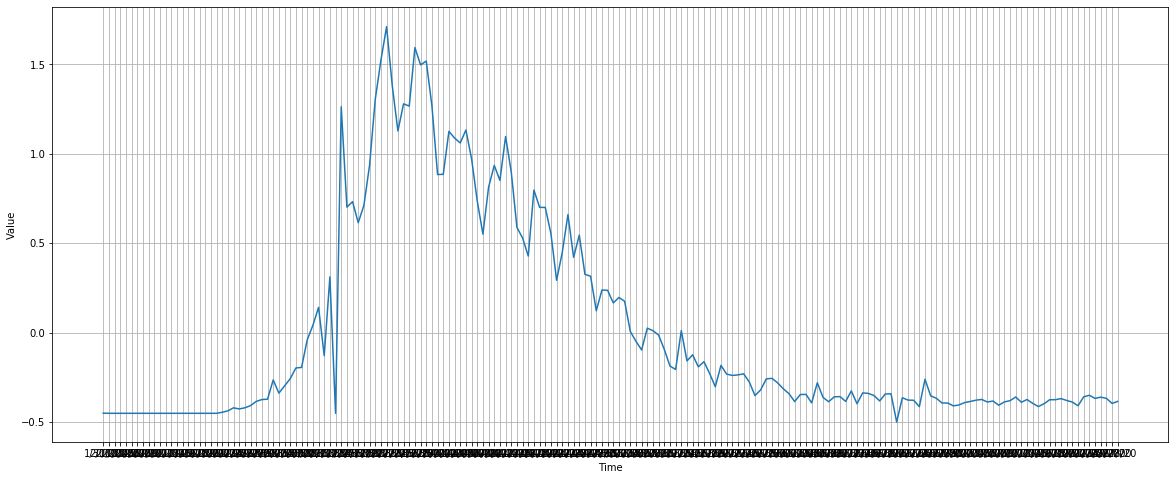

In [8]:
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(20, 8))
plot_series(ITtime,ITseries)

In [9]:
split_time = int(0.8 * ITseries.shape[0])
time_train = ITtime[:split_time]
x_train = ITseries[:split_time]
time_valid = ITtime[split_time:]
x_valid = ITseries[split_time:]

window_size = 10
batch_size = 5
shuffle_buffer_size = 500

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(5).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
import tensorflow as tf
import numpy as np


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size = 64
#batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(next(iter(train_set.take(5))))
# print(x_train.shape)

model = tf.keras.models.Sequential([
  
  tf.keras.layers.Conv1D(filters=50, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.LeakyReLU()
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

x = model.evaluate(test_set)


Epoch 1/100
27/27 [==============================] - 9s 335ms/step - loss: 0.4963 - mae: 0.4969
Epoch 2/100
27/27 [==============================] - 2s 76ms/step - loss: 0.4963 - mae: 0.4969: 2s - lo
Epoch 3/100
27/27 [==============================] - 2s 78ms/step - loss: 0.4963 - mae: 0.4969: 0s - loss: 0.5057 - mae: 0.50
Epoch 4/100
27/27 [==============================] - 2s 78ms/step - loss: 0.4963 - mae: 0.4969
Epoch 5/100
27/27 [==============================] - 2s 72ms/step - loss: 0.4963 - mae: 0.4969
Epoch 6/100
27/27 [==============================] - 2s 72ms/step - loss: 0.4963 - mae: 0.4969
Epoch 7/100
27/27 [==============================] - 2s 64ms/step - loss: 0.4963 - mae: 0.4969
Epoch 8/100
27/27 [==============================] - 1s 47ms/step - loss: 0.4963 - mae: 0.4969
Epoch 9/100
27/27 [==============================] - 1s 46ms/step - loss: 0.4963 - mae: 0.4969: 1s - loss: 0.451
Epoch 10/100
27/27 [==============================] - 2s 61ms/step - loss: 0.4963 - ma

27/27 [==============================] - 3s 125ms/step - loss: 0.3169 - mae: 0.3175
Epoch 84/100
27/27 [==============================] - 3s 94ms/step - loss: 0.3352 - mae: 0.3359
Epoch 85/100
27/27 [==============================] - 2s 88ms/step - loss: 0.3102 - mae: 0.3108
Epoch 86/100
27/27 [==============================] - 2s 80ms/step - loss: 0.2999 - mae: 0.3005
Epoch 87/100
27/27 [==============================] - 2s 91ms/step - loss: 0.3677 - mae: 0.3687
Epoch 88/100
27/27 [==============================] - 2s 85ms/step - loss: 0.3114 - mae: 0.3122
Epoch 89/100
27/27 [==============================] - 3s 105ms/step - loss: 0.3641 - mae: 0.3651 2s - loss: 0.5
Epoch 90/100
27/27 [==============================] - 2s 74ms/step - loss: 0.3079 - mae: 0.3088
Epoch 91/100
27/27 [==============================] - 2s 82ms/step - loss: 0.3113 - mae: 0.3124
Epoch 92/100
27/27 [==============================] - 3s 94ms/step - loss: 0.2942 - mae: 0.2948
Epoch 93/100
27/27 [================

(5.655877526068171e-09,
 0.0015757960743081156,
 0.24490981408770185,
 0.5089507868999977)

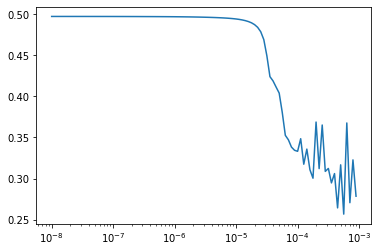

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis()

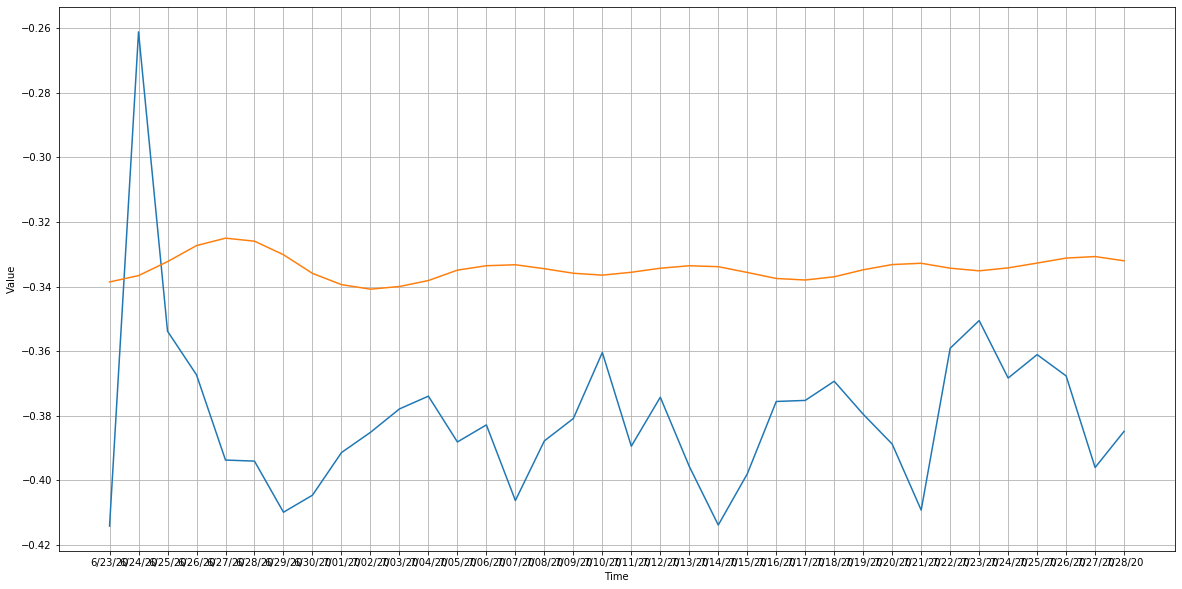

In [14]:
# plotting validation of ITALY
rnn_forecast = model_forecast(model, ITseries[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

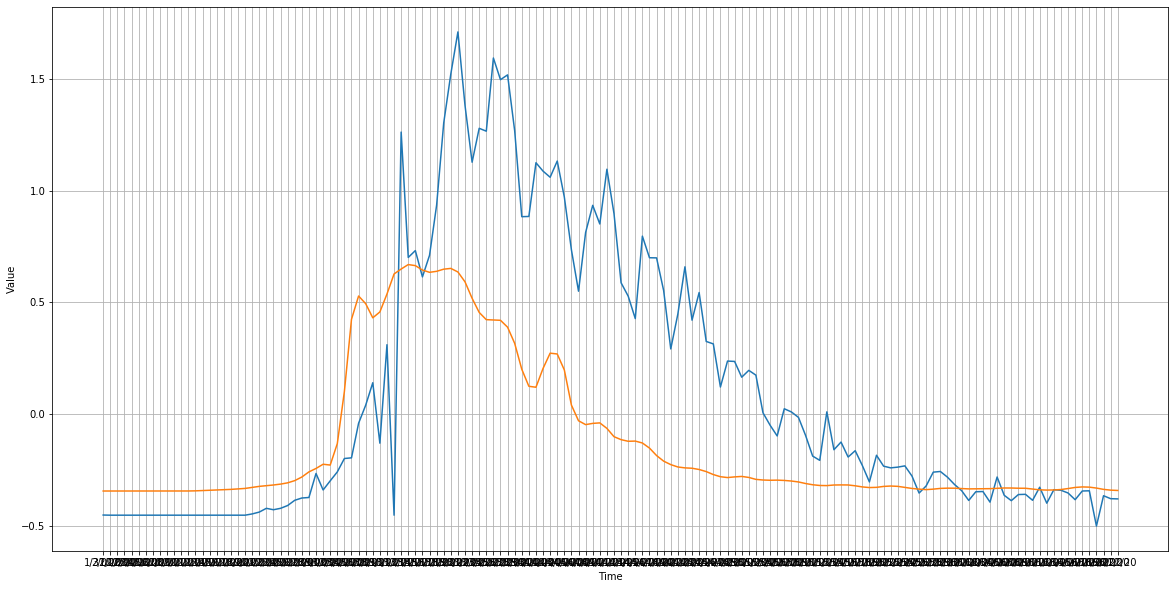

In [16]:
# plotting traning of ITALY
rnn_forecast = model_forecast(model, ITseries[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[ : split_time, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_train, x_train)
plot_series(time_train, rnn_forecast)

In [17]:
url = 'https://api.thevirustracker.com/free-api?countryTimeline=EG'

x = requests.post(url) 

#print (x.content)
Data= json.loads(x.content)['timelineitems'][0]
 

In [18]:
EGdata= pd.DataFrame(Data)
EGdata

2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  \
new_daily_cases         1        0        0        0        0        0   
new_daily_deaths        0        0        0        0        0        0   
total_cases             1        1        1        1        1        1   
total_recoveries        0        0        0        0        0        0   
total_deaths            0        0        0        0        0        0   

                  2/20/20  2/21/20  2/22/20  2/23/20  ...  7/20/20  7/21/20  \
new_daily_cases         0        0        0        0  ...      627      676   
new_daily_deaths        0        0        0        0  ...       50       47   
total_cases             1        1        1        1  ...    88402    89078   
total_recoveries        0        0        0        0  ...    21718    21718   
total_deaths            0        0        0        0  ...     4352     4399   

                  7/22/20  7/23/20  7/24/20  7/25/20  7/26/20  7/27/20  \
new_daily_cases       667      668      659      511      479      420   
new_daily_deaths       41       40       38       40       48       46   
total_cases         89745    90413    91072    91583    92062    92482   
total_recoveries    21718    21718    21718    21718    21718    21718   
total_deaths         4440     4480     4518     4558     4606     4652   

                  7/28/20  stat  
new_daily_cases       465    ok  
new_daily_deaths       39    ok  
total_cases         92947    ok  
total_recoveries    21718    ok  
total_deaths         4691    ok  

[5 rows x 167 columns]

In [19]:
EGdata= pd.DataFrame(Data)
EGseries = EGdata.iloc[0].to_numpy()
EGseries = EGseries[:-1]
EGseries = EGseries.astype('float32')
mean= np.mean(EGseries)
var= np.var(EGseries)
EGseries = ((EGseries - mean)/var)*1000
EGseries

array([-1.7849033 , -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7880968 , -1.7849033 , -1.7880968 , -1.7880968 , -1.7880968 ,
       -1.7849033 , -1.749775  , -1.7880968 , -1.6795185 , -1.7689358 ,
       -1.7753228 , -1.7849033 , -1.7657423 , -1.7465816 , -1.695486  ,
       -1.7849033 , -1.6603576 , -1.6411967 , -1.7880968 , -1.596488  ,
       -1.695486  , -1.7593554 , -1.682712  , -1.6635511 , -1.6731316 ,
       -1.615649  , -1.6635511 , -1.6571642 , -1.6603576 , -1.682712  ,
       -1.6380032 , -1.615649  , -1.5677469 , -1.5134578 , -1.4048795 ,
       -1.5166513 , -1.4591687 , -1.3122686 , -1.3793317 , -1.4368143 ,
       -1.3442035 , -1.4847164 , -1.3250426 , -1.3857187 , -1.3889121 ,
       -1.2771405 , -1.2931079 , -1.2515926 , -1.2420123 , -1.1877232 ,
       -1.4304273 , -1.1845297 , -1.2867209 , -1.2483991 , -1.04

In [20]:
EGtime = EGdata.columns.tolist()
EGtime = EGtime[:-1]


In [35]:
split_time = int(0.95 * EGseries.shape[0])
time_train = EGtime[:split_time]
x_train = EGseries[:split_time]
time_valid = EGtime[split_time:]
x_valid = EGseries[split_time:]


In [23]:
# Transfar learning 

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

x = model.evaluate(test_set)

Epoch 1/100
27/27 [==============================] - 2s 66ms/step - loss: 0.2808 - mae: 0.2821
Epoch 2/100
27/27 [==============================] - 3s 93ms/step - loss: 0.2808 - mae: 0.2821
Epoch 3/100
27/27 [==============================] - 2s 77ms/step - loss: 0.2808 - mae: 0.2821
Epoch 4/100
27/27 [==============================] - 2s 82ms/step - loss: 0.2808 - mae: 0.2821
Epoch 5/100
27/27 [==============================] - 1s 54ms/step - loss: 0.2808 - mae: 0.2821
Epoch 6/100
27/27 [==============================] - 2s 81ms/step - loss: 0.2808 - mae: 0.2820
Epoch 7/100
27/27 [==============================] - 2s 79ms/step - loss: 0.2807 - mae: 0.2820
Epoch 8/100
27/27 [==============================] - 2s 78ms/step - loss: 0.2807 - mae: 0.2820
Epoch 9/100
27/27 [==============================] - 2s 81ms/step - loss: 0.2807 - mae: 0.2820
Epoch 10/100
27/27 [==============================] - 2s 74ms/step - loss: 0.2807 - mae: 0.2820
Epoch 11/100
27/27 [=============================

27/27 [==============================] - 4s 162ms/step - loss: 0.1952 - mae: 0.1960
Epoch 85/100
27/27 [==============================] - 4s 155ms/step - loss: 0.1953 - mae: 0.1961
Epoch 86/100
27/27 [==============================] - 2s 63ms/step - loss: 0.1932 - mae: 0.1940
Epoch 87/100
27/27 [==============================] - 3s 101ms/step - loss: 0.1957 - mae: 0.1965
Epoch 88/100
27/27 [==============================] - 3s 97ms/step - loss: 0.1928 - mae: 0.1936
Epoch 89/100
27/27 [==============================] - 2s 85ms/step - loss: 0.1932 - mae: 0.1940
Epoch 90/100
27/27 [==============================] - 3s 125ms/step - loss: 0.1881 - mae: 0.1889
Epoch 91/100
27/27 [==============================] - 3s 98ms/step - loss: 0.2173 - mae: 0.2183: 1s - loss: 0.3203 - m
Epoch 92/100
27/27 [==============================] - 4s 138ms/step - loss: 0.2078 - mae: 0.2085
Epoch 93/100
27/27 [==============================] - 3s 121ms/step - loss: 0.2036 - mae: 0.2045
Epoch 94/100
27/27 [====

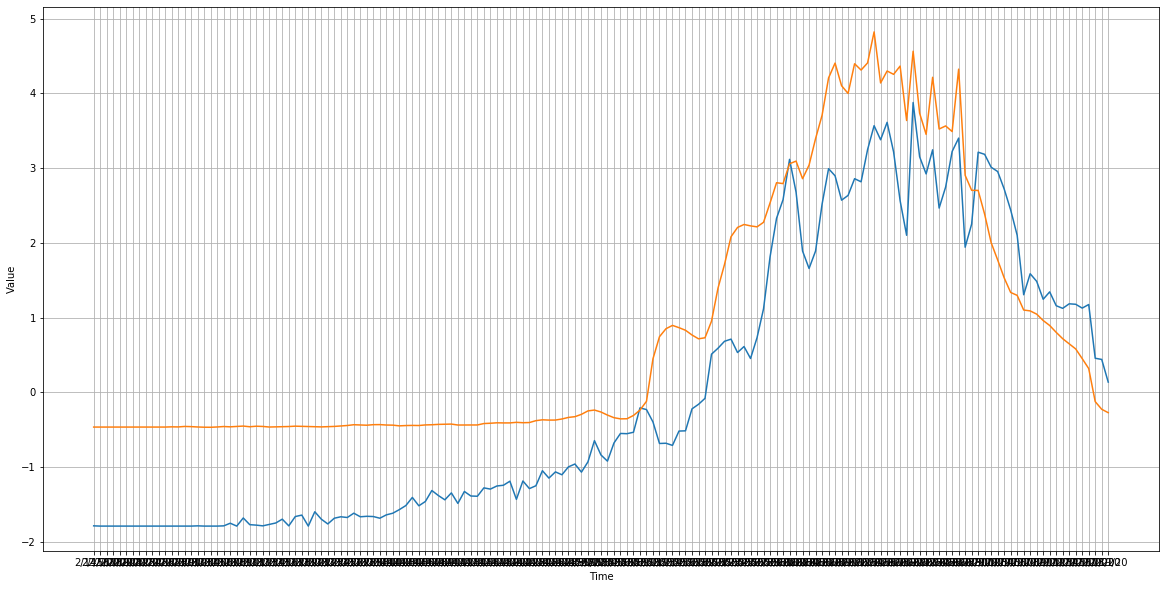

In [36]:
# plotting all Egypt Data (training and validation)
rnn_forecast = model_forecast(model, EGseries[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[ : split_time, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_train, x_train)
plot_series(time_train, rnn_forecast)